In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from loaders import clean_text_for_pattern_letter
from temp_text_puh import template_str
# input_str = clean_text_for_pattern_letter(template_str, out_len=len(template_str))
input_str = clean_text_for_pattern_letter(template_str, out_len=500)
input_str = '<' + input_str + '>'
print(len(input_str))
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
           'v', 'w', 'x', 'y', 'z', ' ', '.', ',', '<', '\'', '>']
print(f'{letters=}')
# print(f'{input_str=}')

len(letters)=32
502
letters=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '.', ',', '<', "'", '>']


In [3]:
# generate SDR

SDR_len = 128 # 128
sparsity = 4 # 4
max_overlap = 1 # 1

sparse_prob = sparsity / SDR_len

letter_SDRs = {}

for letter in letters:
    while True:
        rnd_SDR = np.random.choice([0, 1], SDR_len, True, [1 - sparse_prob, sparse_prob])

        if (rnd_SDR > 0).sum() != sparsity:
            continue
        
        is_over_max = False
        for SDR in letter_SDRs.values():
            if (SDR & rnd_SDR).sum() > max_overlap:
                is_over_max = True
                break
        
        if is_over_max:
            continue
            
        break
    
    # print(f'{letter}')
    letter_SDRs.setdefault(letter, rnd_SDR)

for letter, SDR in letter_SDRs.items():
    print(f'{letter} : {(SDR > 0).sum()} {SDR.tolist()}')

a : 4 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
b : 4 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
c : 4 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [4]:
# text to SDRs
input_SDRs = []

for inp in input_str:
    input_SDRs.append(letter_SDRs[inp])

print(f'{len(input_SDRs)=}')

# for SDR in input_SDRs:
#     print(f'{SDR.tolist()}')

len(input_SDRs)=502


In [5]:
# init start column
column_size = 16

start_SDR = letter_SDRs['<']

start_I = np.zeros((start_SDR.size, column_size))

active_start_SDR_idx = np.where(start_SDR == 1)

for as_idx in active_start_SDR_idx[0]:
    rnd_active = np.random.randint(column_size)

    start_I[as_idx][rnd_active] = 1

# for col in np.rot90(start_I):
#     print(f'{col.astype(int).tolist()}')

In [6]:
I = np.zeros((SDR_len, column_size))
O = np.zeros((SDR_len, column_size))

W = np.random.rand(SDR_len, column_size, SDR_len * column_size) * 1e-2

V = np.zeros((SDR_len, column_size))

TR = np.zeros((SDR_len, column_size))
PO = np.zeros((SDR_len, column_size))

prec = 1e-30

# train

epoch_cnt = 3

eps0 = 0.003
TR_eps0 = 0.03 * 4 # 0.15

eps0_V = 0.09

coef_TR = 0.8

for epoch_idx in range(epoch_cnt):
    I = np.copy(start_I)

    for SDR in input_SDRs[1:]:
        rsh_I = I.reshape(SDR_len * column_size)

        O = np.dot(W, rsh_I)

        O /= np.max(np.abs(O)) + prec
        
        # threshold
        min_O = np.min(O)
        O[O < TR * coef_TR] = min_O
        OO = np.copy(O)

        # boosting
        nV = np.abs(V - np.max(V, axis=1)[np.newaxis].T)
        nV /= np.max(nV, axis=1)[np.newaxis].T + prec

        OV = O + nV * eps0_V

        OV *= SDR[np.newaxis].T
        max_O = np.max(OV, axis=1)

        O *= SDR[np.newaxis].T
        O[OV < max_O[np.newaxis].T] = 0
        max_O_idx = np.where(O != 0)

        W[max_O_idx] += (rsh_I - W[max_O_idx] * O[max_O_idx][..., np.newaxis]) * eps0

        # threshold update
        TR[max_O_idx] += (OO[max_O_idx] - TR[max_O_idx] * PO[max_O_idx]) * TR_eps0
        PO[max_O_idx] = np.copy(OO[max_O_idx])

        # winners
        V[max_O_idx] += 1

        # recur
        O[O != 0] = 1

        I = np.copy(O)

# O.shape
print(np.mean(V, axis=1).tolist())
print(np.sum(V == 0))
print(np.sum((V > 0), axis=1).tolist())
# for col in np.rot90(V):
#     print(f'{col.astype(int).tolist()}')
print(f'{np.mean(TR)=} {TR.max()=} {TR.min()=}')

[0.0, 0.0, 4.5, 0.0, 1.6875, 0.0, 0.0, 3.1875, 0.0, 0.0, 0.1875, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0625, 0.0, 7.125, 0.0, 11.0625, 0.0, 6.5625, 0.0, 0.0, 0.0, 17.125, 17.3125, 0.0, 1.5, 0.0, 0.0, 17.0625, 1.3125, 1.6875, 0.0, 0.0, 0.0, 10.5, 0.0, 0.75, 1.3125, 24.25, 9.75, 6.0, 0.0, 0.0, 0.0, 0.0, 6.1875, 0.0, 6.0, 29.625, 0.0, 0.0, 0.0, 1.6875, 18.375, 0.0, 0.0, 6.5625, 6.0, 0.0, 0.0, 0.0, 0.0, 0.75, 0.1875, 11.125, 0.0, 4.125, 1.5, 0.0, 6.375, 1.5, 0.0, 0.0, 9.0, 11.5625, 0.0, 0.0, 0.0, 0.0, 6.75, 0.0, 0.0, 2.4375, 0.0, 3.1875, 2.4375, 0.0, 4.125, 2.4375, 0.0, 0.0, 2.4375, 2.25, 2.625, 0.0, 0.5625, 0.0, 0.0, 1.6875, 2.0625, 0.0, 0.0, 1.6875, 0.0, 5.4375, 0.0, 0.0, 0.0, 0.0, 19.25, 0.0, 6.5625, 6.9375, 0.0, 0.0, 2.4375, 12.0, 6.1875, 0.0, 0.0, 0.0, 0.1875, 9.75]
1331
[0, 0, 14, 0, 8, 0, 0, 12, 0, 0, 1, 12, 0, 0, 0, 0, 0, 16, 0, 15, 0, 16, 0, 14, 0, 0, 0, 16, 16, 0, 7, 0, 0, 16, 6, 8, 0, 0, 0, 16, 0, 5, 6, 16, 16, 15, 0, 0, 0, 0, 16, 0, 16, 16, 0, 0, 0, 9, 16, 0, 0, 16, 16, 0, 0, 0, 0, 5

In [7]:
# test
error = []
over_mean_list = []
entropy_list = []
predictability_list = []
active_out_list = []

I = np.copy(start_I)

infer_coef_TR = 0.0

for SDR in input_SDRs[1:]:
    rsh_I = I.reshape(SDR_len * column_size)

    O = np.dot(W, rsh_I)

    # threshold
    norm_O = O / np.max(np.abs(O)) + prec
    min_O = np.min(O) - 1
    O[norm_O < TR * infer_coef_TR] = min_O

    atr_O = np.copy(O)
    atr_O[norm_O < TR * coef_TR] = min_O

    max_O = np.max(O, axis=1)
    argmax_O_idx = np.argsort(max_O)[::-1][:sparsity]

    SDR_O = np.zeros(O.shape[0])
    SDR_O[argmax_O_idx] = 1

    err = (SDR.astype(int) ^ SDR_O.astype(int)).sum()
    # print(f'{err=}')
    error.append(err)

    # dividers
    over_mean = (max_O > np.mean(max_O)).sum()
    over_mean_list.append(over_mean)

    entropy = np.copy(max_O)
    entropy /= np.linalg.norm(entropy) + prec
    entropy[entropy < 0] = prec
    entropy = -1 * np.sum(entropy * np.log2(entropy))
    entropy_list.append(entropy)

    predictability = np.sum(np.abs(max_O - max_O[np.newaxis].T))
    predictability_list.append(predictability)

    active_out = np.sum(atr_O > min_O)
    active_out_list.append(active_out)

    O *= SDR[np.newaxis].T
    max_O = np.max(O, axis=1)
    O[O < max_O[np.newaxis].T] = 0

    # recur
    O[O != 0] = 1

    I = np.copy(O)

error = np.array(error)
mean_percent = int(np.mean(error) / (2 * sparsity) * 100)
print(f'{np.mean(error)=} {error.max()=} {error.min()=} {mean_percent=}')

# O.shape
# for col in np.rot90(O):
#     print(f'{col.astype(int).tolist()}')

np.mean(error)=0.7704590818363274 error.max()=8 error.min()=0 mean_percent=9


In [8]:
from numpy import ndarray

dividers: dict[str, ndarray] = {}

dividers.setdefault('error', np.array(error, dtype='float'))
dividers.setdefault('predictability', np.array(predictability_list, dtype='float'))
dividers.setdefault('over_mean', np.array(over_mean_list, dtype='float'))
dividers.setdefault('entropy', np.array(entropy_list, dtype='float'))
dividers.setdefault('active_out', np.array(active_out_list, dtype='float'))

# dividers['over_mean'] = 1 / dividers['over_mean']
# dividers['entropy'] = 1 / dividers['entropy']
# dividers['active_out'] = 1 / dividers['active_out']

for dv_key, dv in dividers.items():
    dividers[dv_key] = dv / np.max(np.abs(dv)) + prec


dv_key='error'


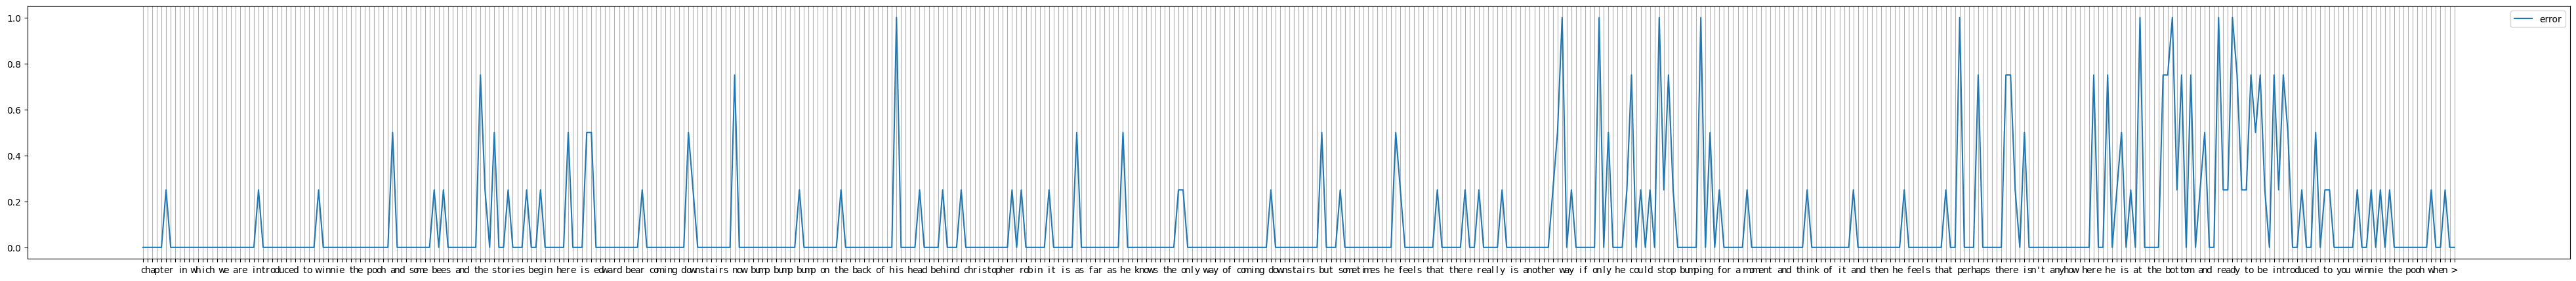

dv_key='predictability'


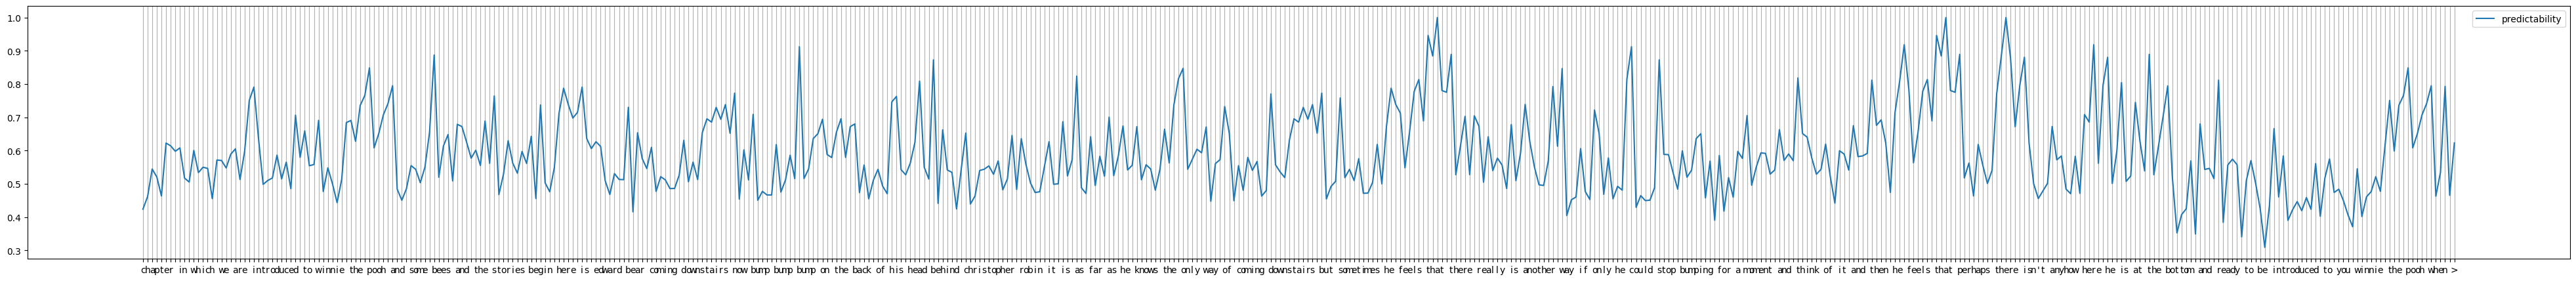

dv_key='over_mean'


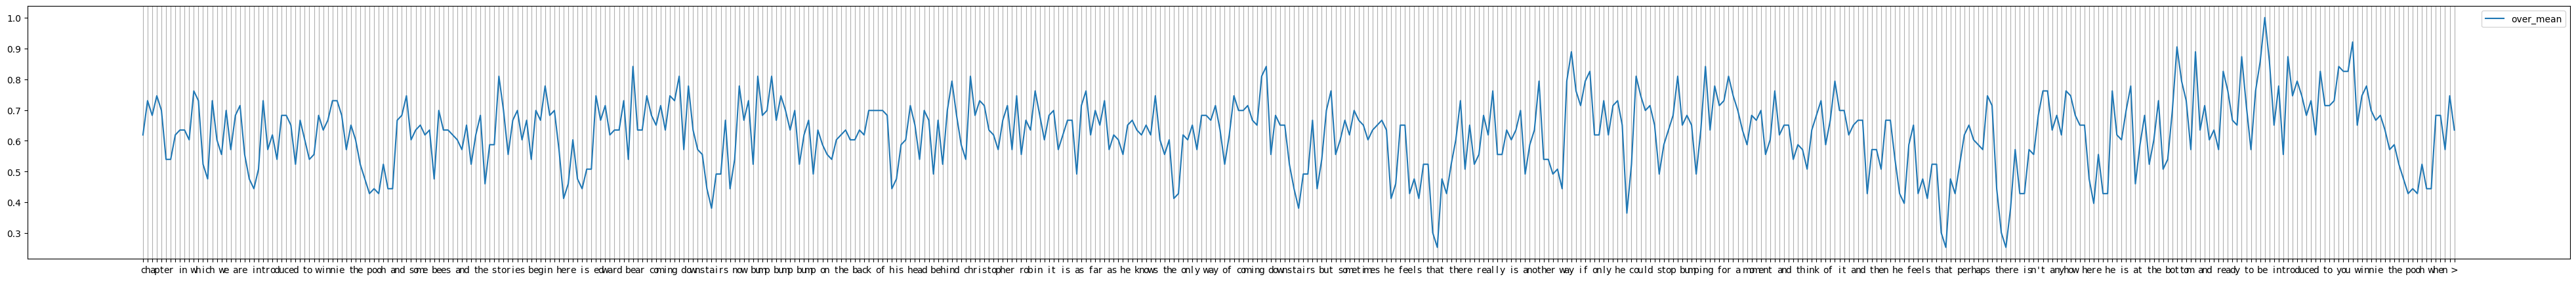

dv_key='entropy'


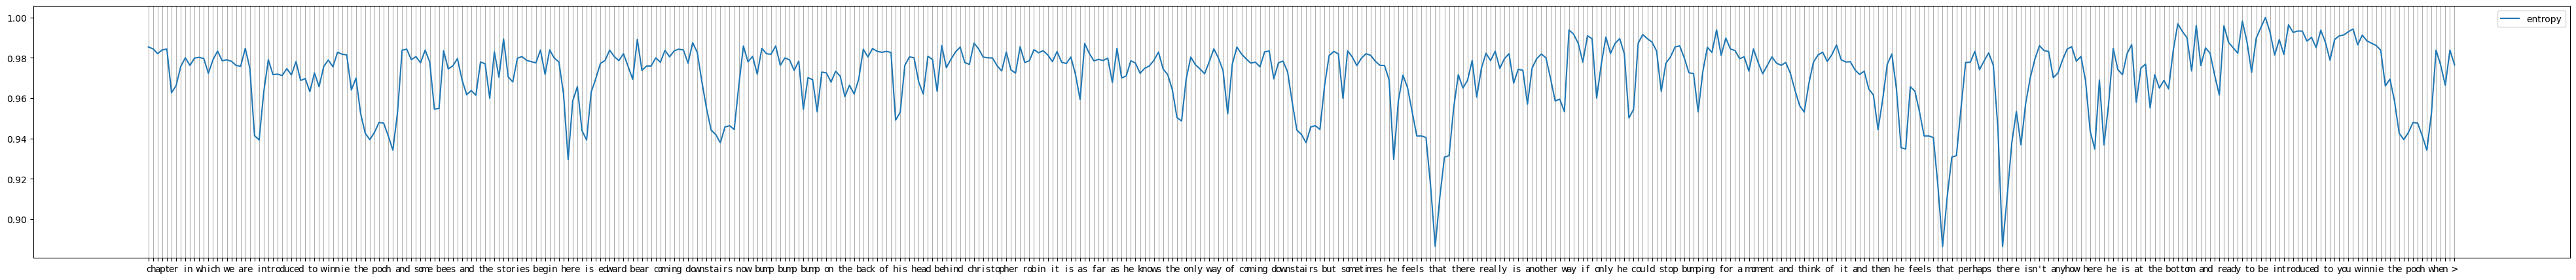

dv_key='active_out'


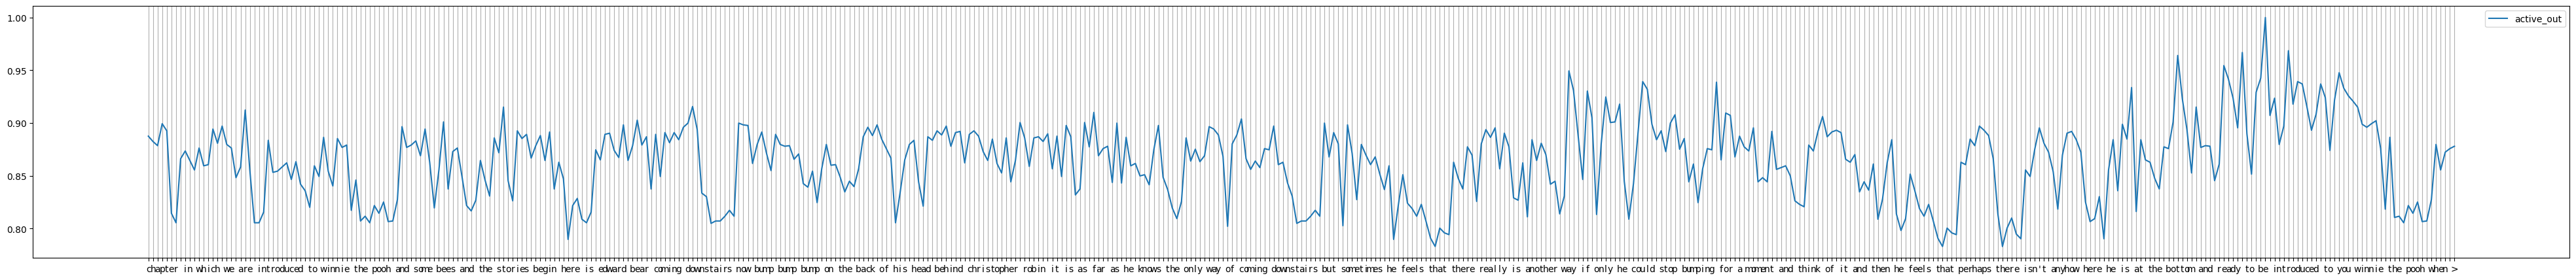

In [9]:
for dv_key, dv in dividers.items():
    plt.figure(figsize=(50, 5))

    plt.plot(np.arange(len(dv)), dv, label = dv_key)

    plt.xticks(np.arange(len(input_str[1:])), input_str[1:])
    plt.grid(visible=True, axis='x')

    plt.legend()
    print(f'{dv_key=}')
    plt.show()
    
    plt.close()

In [10]:
from numpy import ndarray

def get_diff_0(C: ndarray):
    return np.copy(C)

def get_diff_1(C: ndarray):
    return C - np.pad(C, (1, 0))[:-1]


def get_diff_2(C: ndarray):
    diff_C = get_diff_1(C)

    return diff_C - np.pad(diff_C, (1, 0))[:-1]


a = np.arange(1, 10)**2
print(a)
c = get_diff_1(a)
print(c)
c = get_diff_2(a)
print(c)


[ 1  4  9 16 25 36 49 64 81]
[ 1  3  5  7  9 11 13 15 17]
[1 2 2 2 2 2 2 2 2]


In [11]:
def divide_by_peak(C: ndarray, inputs: list, is_gt: bool = True):
    substrings: dict[str, int] = {}
    buffer = []

    peaks: dict[int, int] = {}

    for inp_idx, inp in enumerate(inputs):
        buffer.append(inp)

        if inp_idx == 0 or inp_idx >= len(inputs) - 2:
            continue

        C_idx = inp_idx # + 1

        if (is_gt and C[C_idx] > C[C_idx - 1] and C[C_idx] > C[C_idx + 1]) or \
                (not is_gt and C[C_idx] < C[C_idx - 1] and C[C_idx] < C[C_idx + 1]):
            substr = ''.join(buffer)

            substrings.setdefault(substr, 0)
            substrings[substr] += 1

            buffer = []

            peaks.setdefault(inp_idx, 1)

    # sort
    substrings = dict(sorted(substrings.items(), key=lambda item: item[1], reverse=True))

    peaks.setdefault((len(inputs) - 1), 1)

    return substrings, peaks


In [12]:
def divide_by_cliff(C: ndarray, inputs: list, is_gt: bool = True):
    substrings: dict[str, int] = {}
    buffer = []

    cliffs: dict[int, int] = {}

    for inp_idx, inp in enumerate(inputs):
        buffer.append(inp)

        if inp_idx == 0 or inp_idx >= len(inputs) - 1:
            continue

        C_idx = inp_idx # + 1

        if (is_gt and C[C_idx] > C[C_idx - 1]) or (not is_gt and C[C_idx] < C[C_idx - 1]):
            substr = ''.join(buffer)

            substrings.setdefault(substr, 0)
            substrings[substr] += 1

            buffer = []

            cliffs.setdefault(inp_idx, 1)

    # sort
    substrings = dict(sorted(substrings.items(), key=lambda item: item[1], reverse=True))

    cliffs.setdefault((len(inputs) - 1), 1)

    return substrings, cliffs


In [13]:
# generate dividers
get_diff_list = [get_diff_0, get_diff_1, get_diff_2]
divide_by_list = [divide_by_cliff, divide_by_peak]
gt_list = [True, False]

divide_idx: dict[str, dict[int, int]] = {}

dv_stats = {}
dv_stats_2 = {}

for dv_key, dv in dividers.items():
    for get_diff in get_diff_list: 
        for divide_by in divide_by_list:
            for gt in gt_list:
                temp_dv = get_diff(dv)
                substrings, dv_idx = divide_by(temp_dv, inputs=input_str, is_gt=gt)

                dv_idx_key = f'{dv_key}_{get_diff.__name__}_{divide_by.__name__}_gt={gt}'
                
                # sbs = np.array(list(substrings.values())).sum()
                sbs = np.mean(np.array(list(substrings.values()))) # / len(substrings)
                # sbs = 1 / len(substrings)
                # sbs = len(dv_idx) / len(substrings)

                # print(f'{dv_idx_key} : {sbs=}')
                dv_stats.setdefault(dv_idx_key, sbs)
                dv_stats_2.setdefault(dv_idx_key, len(substrings))

                divide_idx.setdefault(dv_idx_key, dv_idx)

# test
print(f'{len(divide_idx)=}')

dv_stats = dict(sorted(dv_stats.items(), key=lambda item: item[1], reverse=True))

# for k, v in dv_stats.items():
#     print(f'{k} : {v}')
#     print(f'{k} : {dv_stats_2[k]}')
#     print(f'{k} : {len(divide_idx[k])}')

for k, v in divide_idx.items():
    print(f'{k} : {len(divide_idx[k])} : {list(v.keys())}')

# 500
# predictability_get_diff_1_divide_by_cliff_gt=True
# 5 000
# predictability_get_diff_0_divide_by_cliff_gt=False : 8.095846645367413
# predictability_get_diff_0_divide_by_cliff_gt=False : 8.142857142857142
# predictability_get_diff_0_divide_by_cliff_gt=False : 7.867283950617284
# active_out_get_diff_1_divide_by_cliff_gt=True : 7.890804597701149
# 50 000
# over_mean_get_diff_1_divide_by_cliff_gt=True : 677
# entropy_get_diff_0_divide_by_cliff_gt=True : 629

len(divide_idx)=60
error_get_diff_0_divide_by_cliff_gt=True : 88 : [5, 25, 38, 54, 63, 65, 73, 76, 79, 83, 86, 92, 96, 108, 118, 128, 142, 151, 163, 168, 173, 177, 188, 190, 196, 202, 212, 224, 244, 255, 259, 271, 280, 286, 289, 294, 305, 306, 307, 309, 315, 317, 321, 322, 324, 326, 328, 330, 337, 339, 341, 347, 360, 370, 381, 390, 393, 397, 403, 407, 422, 425, 427, 428, 430, 432, 437, 439, 441, 443, 445, 446, 449, 452, 456, 458, 461, 463, 467, 470, 472, 479, 482, 484, 486, 495, 498, 501]
error_get_diff_0_divide_by_cliff_gt=False : 90 : [6, 26, 39, 55, 64, 66, 74, 75, 77, 80, 84, 87, 93, 98, 109, 119, 120, 129, 143, 152, 164, 169, 174, 178, 189, 191, 197, 203, 213, 226, 245, 256, 260, 272, 273, 281, 287, 290, 295, 308, 310, 316, 318, 323, 325, 327, 329, 331, 332, 338, 340, 342, 348, 361, 371, 382, 391, 394, 398, 405, 406, 408, 423, 426, 429, 431, 433, 440, 442, 444, 447, 450, 453, 454, 457, 459, 460, 462, 464, 465, 468, 471, 474, 480, 483, 485, 487, 496, 499, 501]
error_get_diff_0_divi

In [14]:
def get_upstream_input(input_SDRs: list[ndarray], divide_idx: dict[int, int]) -> list[ndarray]:
    buffer = []
    ups_inputs = []

    for SDR_idx, SDR in enumerate(input_SDRs):
        buffer.append(np.copy(SDR))

        if divide_idx.get(SDR_idx) or SDR_idx == len(input_SDRs) - 1:
            buffer = np.array(buffer)
            buffer = np.sum(buffer, axis=0)
            buffer[buffer > 1] = 1

            ups_inputs.append(buffer)

            buffer = []

    return ups_inputs

ups_inputs = get_upstream_input(input_SDRs, divide_idx=divide_idx['predictability_get_diff_0_divide_by_peak_gt=False'])

print(f'{len(ups_inputs)=}')
for ups_inp in ups_inputs:
    print((ups_inp == 1).sum(), ups_inp.size, ups_inp.tolist())

len(ups_inputs)=163
20 128 [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0]
11 128 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]
12 128 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,

In [78]:
def train(ups_inputs: list[ndarray], 
          SDR_len = 128,
          push_delta=0.04,
          epoch_cnt=1,
          sparsity=4,
          eps0=0.01,
          eps0_V=0.09,
          EPS0=0.01,
          TR_coef=0.5,
          TR_eps0=0.01,
          ) -> tuple[ndarray, ndarray] :
    I = np.zeros(SDR_len)
    K = np.zeros(SDR_len)

    S = np.random.rand(SDR_len, SDR_len) * 1e-2

    V = np.zeros(SDR_len)

    TR = np.zeros(SDR_len)
    PO = np.zeros(SDR_len)

    prec = 1e-30

    inputs_idx = np.arange(len(ups_inputs))

    for epoch_idx in range(epoch_cnt):
        np.random.shuffle(inputs_idx)

        EPS = (epoch_cnt - epoch_idx) * EPS0

        for SDR_idx in inputs_idx:
            I = np.copy(ups_inputs[SDR_idx])

            K = np.dot(S, I)

            K /= np.max(np.abs(K)) + prec

            print(f'{(K >= TR * TR_coef).sum()=}')

            # threshold
            if (K >= TR * TR_coef).sum() > 0:
                K[K < TR * TR_coef] = np.min(K)

            # boosting
            nV = np.abs(V - np.max(V))
            nV /= np.max(nV) + prec

            OV = K + nV * eps0_V

            max_O_idx = np.argsort(OV)[::-1][:sparsity]
            pull_idx = max_O_idx[0]
            push_idx = max_O_idx[1:sparsity]

            # eps
            # eps = np.zeros(K.shape)
            # eps[max_O_idx] = eps0 * ((np.linalg.norm(S[max_O_idx], axis=1) - 1)**2)

            S[pull_idx] += (I - S[pull_idx] * K[pull_idx][np.newaxis].T) * EPS # eps[pull_idx][np.newaxis].T
            S[push_idx] += (I - S[push_idx] * K[push_idx][np.newaxis].T) * (-push_delta) * EPS # eps[push_idx][np.newaxis].T

            # threshold update
            TR[pull_idx] += (K[pull_idx] - TR[pull_idx] * PO[pull_idx]) * TR_eps0
            PO[pull_idx] = np.copy(K[pull_idx])

            # winners
            V[pull_idx] += 1

    print(f'{np.sum(V == 0)=}')

    return S, V, TR

In [79]:
def get_SDRs(S: ndarray, 
             TR: ndarray, 
             ups_inputs: list[ndarray], 
             TR_coef=0.5,
             sparsity=4, 
             prec=1e-30) -> tuple[list[ndarray], list[ndarray]]:
    SDRs = []
    Ks = []

    print(f'{len(ups_inputs)=}')
    for I in ups_inputs:
        O = np.dot(S, I)

        O /= np.max(np.abs(O)) + prec

        O[O < TR * TR_coef] = np.min(O)
        
        Ks.append(np.copy(O))

        winners = np.argsort(O)[::-1][:sparsity]

        SDR = np.zeros(O.size)
        SDR[winners] = 1
        SDRs.append(SDR)

    return SDRs, Ks


In [89]:
def context_predict(W: ndarray,
                    V: ndarray,
                    S: ndarray,
                    divide_idx: dict[int, int],
                    input_SDRs: list[ndarray],
                    start_I: ndarray,
                    ds_SDRs: list[ndarray],
                    ds_K: list[ndarray],
                    SDR_len = 128,
                    column_size = 32,
                    sparsity = 4,
                    ) -> list:
    error = []

    I = np.copy(start_I)

    iter_K = iter(ds_K)
    ds_I = next(iter_K)

    for SDR_idx, SDR in enumerate(input_SDRs[1:]):
        rsh_I = I.reshape(SDR_len * column_size)

        O = np.dot(W, rsh_I)

        max_O = np.max(O, axis=1)

        # downstream
        if divide_idx.get(SDR_idx):
            ds_I = next(iter_K)
        
        ds_O = np.dot(S.T, ds_I)
        ds_O /= np.max(np.abs(ds_O)) + prec

        max_O = max_O * ds_O
        # max_O = max_O + ds_O * 0.5

        # predicted SDR
        argmax_O_idx = np.argsort(max_O)[::-1][:sparsity]

        SDR_O = np.zeros(O.shape[0])
        SDR_O[argmax_O_idx] = 1

        err = (SDR.astype(int) ^ SDR_O.astype(int)).sum()
        # print(f'{err=}')
        error.append(err)

        O *= SDR[np.newaxis].T
        max_2_O = np.max(O, axis=1)
        O[O < max_2_O[np.newaxis].T] = 0

        # recur
        O[O != 0] = 1

        I = np.copy(O)
    
    return error


In [98]:
# test dividers

for dv_k in list(divide_idx.keys())[13:14]:
    dv = divide_idx[dv_k]
    print(f'{dv_k} : {len(dv)=}')

    ups_inputs = get_upstream_input(input_SDRs=input_SDRs, divide_idx=dv)

    TR_coef = 0.8
    S, us_V, TR = train(ups_inputs=ups_inputs,
                    SDR_len=SDR_len,
                    push_delta=0.04,
                    epoch_cnt=100,
                    sparsity=sparsity,
                    eps0=0.0,
                    eps0_V=0.0,
                    EPS0=0.01,
                    TR_coef=TR_coef,
                    TR_eps0=0.001,
                    )
    
    L2_SDRs, L2_Ks = get_SDRs(S=S, TR=TR, TR_coef=TR_coef, ups_inputs=ups_inputs, sparsity=sparsity)

    ctx_error = context_predict(W=W,
                                V=V,
                                S=S,
                                divide_idx=dv,
                                ds_SDRs=L2_SDRs,
                                ds_K=L2_Ks,
                                input_SDRs=input_SDRs,
                                start_I=start_I,
                                SDR_len=SDR_len,
                                column_size=column_size,
                                sparsity=sparsity,)

    ctx_error = np.array(ctx_error)
    mean_percent = int(np.mean(ctx_error) / (2 * sparsity) * 100)
    print(f'{np.mean(ctx_error)=} {ctx_error.max()=} {ctx_error.min()=} {mean_percent=}')

    print(f'------------')


predictability_get_diff_0_divide_by_cliff_gt=False : len(dv)=230
(K >= TR * TR_coef).sum()=128
(K >= TR * TR_coef).sum()=127
(K >= TR * TR_coef).sum()=125
(K >= TR * TR_coef).sum()=125
(K >= TR * TR_coef).sum()=121
(K >= TR * TR_coef).sum()=124
(K >= TR * TR_coef).sum()=120
(K >= TR * TR_coef).sum()=117
(K >= TR * TR_coef).sum()=114
(K >= TR * TR_coef).sum()=106
(K >= TR * TR_coef).sum()=122
(K >= TR * TR_coef).sum()=122
(K >= TR * TR_coef).sum()=119
(K >= TR * TR_coef).sum()=104
(K >= TR * TR_coef).sum()=111
(K >= TR * TR_coef).sum()=122
(K >= TR * TR_coef).sum()=108
(K >= TR * TR_coef).sum()=117
(K >= TR * TR_coef).sum()=108
(K >= TR * TR_coef).sum()=99
(K >= TR * TR_coef).sum()=110
(K >= TR * TR_coef).sum()=104
(K >= TR * TR_coef).sum()=102
(K >= TR * TR_coef).sum()=101
(K >= TR * TR_coef).sum()=103
(K >= TR * TR_coef).sum()=86
(K >= TR * TR_coef).sum()=99
(K >= TR * TR_coef).sum()=98
(K >= TR * TR_coef).sum()=102
(K >= TR * TR_coef).sum()=101
(K >= TR * TR_coef).sum()=113
(K >= TR 

(K >= TR * TR_coef).sum()=8
(K >= TR * TR_coef).sum()=9
(K >= TR * TR_coef).sum()=38
(K >= TR * TR_coef).sum()=11
(K >= TR * TR_coef).sum()=18
(K >= TR * TR_coef).sum()=12
(K >= TR * TR_coef).sum()=31
(K >= TR * TR_coef).sum()=12
(K >= TR * TR_coef).sum()=73
(K >= TR * TR_coef).sum()=89
(K >= TR * TR_coef).sum()=5
(K >= TR * TR_coef).sum()=7
(K >= TR * TR_coef).sum()=52
(K >= TR * TR_coef).sum()=4
(K >= TR * TR_coef).sum()=23
(K >= TR * TR_coef).sum()=9
(K >= TR * TR_coef).sum()=15
(K >= TR * TR_coef).sum()=7
(K >= TR * TR_coef).sum()=2
(K >= TR * TR_coef).sum()=2
(K >= TR * TR_coef).sum()=9
(K >= TR * TR_coef).sum()=3
(K >= TR * TR_coef).sum()=53
(K >= TR * TR_coef).sum()=2
(K >= TR * TR_coef).sum()=3
(K >= TR * TR_coef).sum()=2
(K >= TR * TR_coef).sum()=25
(K >= TR * TR_coef).sum()=3
(K >= TR * TR_coef).sum()=10
(K >= TR * TR_coef).sum()=25
(K >= TR * TR_coef).sum()=7
(K >= TR * TR_coef).sum()=5
(K >= TR * TR_coef).sum()=47
(K >= TR * TR_coef).sum()=40
(K >= TR * TR_coef).sum()=94
(K